### Test notebook for OD experiments


In [1]:
# Perform imports
import torch
import numpy as np
from torchvision.models import detection
from matplotlib import pyplot as plt
import cv2
from tqdm.notebook import tqdm
import signal
from datetime import datetime
from torch.utils.data import DataLoader, Dataset

# Global config
plt.rcParams['figure.figsize'] = (20, 10)


In [2]:
# determine device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", DEVICE)

COCO_LABELS = [
    'person',
    'bicycle',
    'car',
    'motorcycle',
    'airplane',
    'bus',
    'train',
    'truck',
    'boat',
    'traffic light',
    'fire hydrant',
    'street sign',
    'stop sign',
    'parking meter',
    'bench',
    'bird',
    'cat',
    'dog',
    'horse',
    'sheep',
    'cow',
    'elephant',
    'bear',
    'zebra',
    'giraffe',
    'hat',
    'backpack',
    'umbrella',
    'shoe',
    'eye glasses',
    'handbag',
    'tie',
    'suitcase',
    'frisbee',
    'skis',
    'snowboard',
    'sports ball',
    'kite',
    'baseball bat',
    'baseball glove',
    'skateboard',
    'surfboard',
    'tennis racket',
    'bottle',
    'plate',
    'wine glass',
    'cup',
    'fork',
    'knife',
    'spoon',
    'bowl',
    'banana',
    'apple',
    'sandwich',
    'orange',
    'broccoli',
    'carrot',
    'hot dog',
    'pizza',
    'donut',
    'cake',
    'chair',
    'couch',
    'potted plant',
    'bed',
    'mirror',
    'dining table',
    'window',
    'desk',
    'toilet',
    'door',
    'tv',
    'laptop',
    'mouse',
    'remote',
    'keyboard',
    'cell phone',
    'microwave',
    'oven',
    'toaster',
    'sink',
    'refrigerator',
    'blender',
    'book',
    'clock',
    'vase',
    'scissors',
    'teddy bear',
    'hair drier',
    'toothbrush',
    'hair brush',
]

COLORS = np.random.uniform(0, 255, size=(len(COCO_LABELS), 3))

LABEL_DICT = {
    'car': 'vehicle',
    'bus': 'vehicle',
    'truck': 'vehicle',
    'caravan': 'vehicle',
    'trailer': 'vehicle',
    'motorcycle': 'vehicle',
    'train': 'vehicle',
    'bicycle': 'vehicle',
    'person': 'pedestrian',
    'rider': 'pedestrian',
}

# Use pretrained model frcnn-mobilenet
model = detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, progress=True,
                                                        num_classes=len(COCO_LABELS), pretrained_backbone=True).to(DEVICE)
model.eval()


Running on cpu


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequen

### Test model with a single image


In [3]:
def eval_model(model, image):
    image = image.transpose((2, 0, 1))

    # Reformat image data
    image = np.expand_dims(image, axis=0)
    image = image / 255.0
    image = torch.FloatTensor(image)

    # Move data to correct device
    image = image.to(DEVICE)
    return model(image)


def draw_detections(image, detections, tol):
    # Loop over detections
    for i in range(0, len(detections["boxes"])):
        score = detections["scores"][i]

        # Ignore any detections below the tolerance
        if score > tol:
            # Pull important data
            idx = int(detections["labels"][i])
            box = detections["boxes"][i].detach().cpu().numpy()
            (x0, y0, x1, y1) = box.astype("int")
            label = "{}: {:.2f}%".format(COCO_LABELS[idx], score * 100)

            # draw the bounding box and label on the image
            cv2.rectangle(image, (x0, y0), (x1, y1),
                          COLORS[idx], 2)
            y = y0 - 15 if y0 - 15 > 15 else y0 + 15
            cv2.putText(image, label, (x0, y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)

    return image


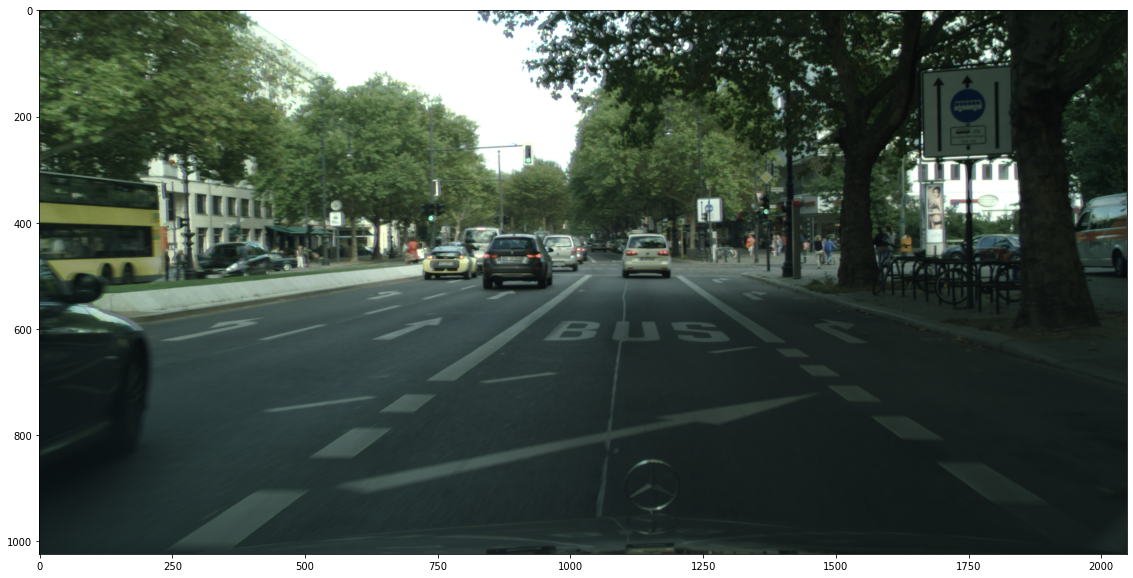

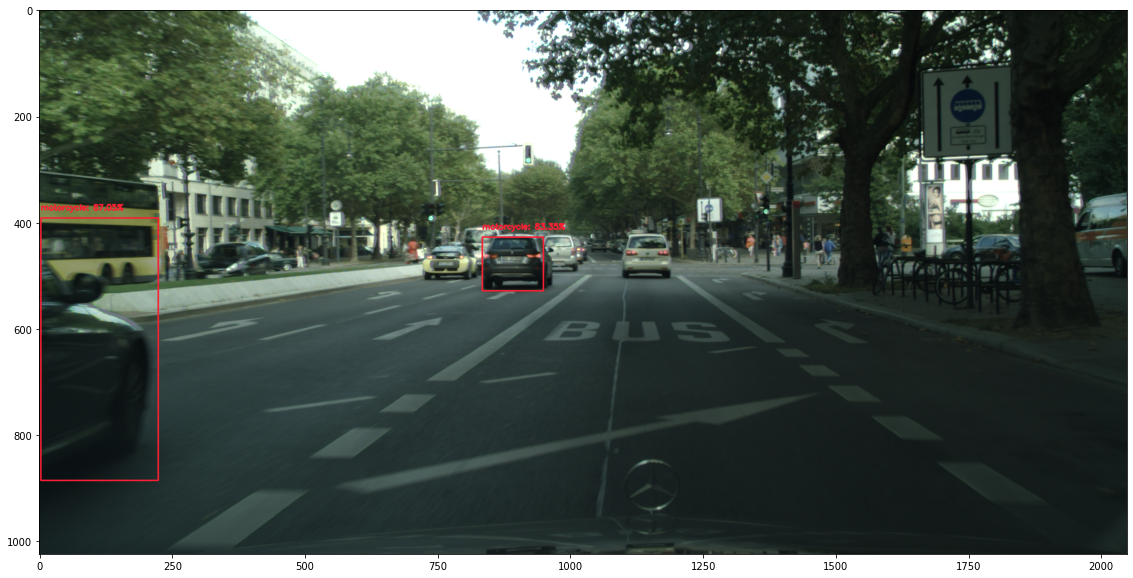

In [4]:
# Load test image
image = cv2.imread(
    "data/datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000000_000019_leftImg8bit.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

orig = image.copy()

plt.imshow(image)
plt.show()

result = eval_model(model, image)

detections = result[0]

box_image = draw_detections(orig, detections, 0.8)

plt.imshow(box_image)
plt.show()


### Run on video


In [5]:
# Prepare video
class VideoDataset(Dataset):

    def __init__(self, vid_path):
        self.vid_path = vid_path
        self.cap = cv2.VideoCapture(vid_path)


    def __len__(self):
        return int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))

    def __getitem__(self, idx):
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        frame = self.cap.read()
        return frame

def collate_fn(batch):
    _, images = zip(*batch)

    data = []
    for image in images:
        orig = image.copy()
        image = image.transpose((2, 0, 1))

        # Reformat image data
        image = np.expand_dims(image, axis=0)
        image = image / 255.0
        image = torch.FloatTensor(image)
        data.append((orig, image))

    return data

    

video_dataset = VideoDataset('data/highway_video.mp4')
video_dataloader = DataLoader(video_dataset, shuffle=False, collate_fn=collate_fn)


In [6]:
# Get reference to video
cap = cv2.VideoCapture('data/highway_video.mp4')
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Get video format
fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
fps = int(cap.get(cv2.CAP_PROP_FPS))
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create video writer
vwriter = cv2.VideoWriter()
vwriter.open(f'data/outputs/highway_video_out_{datetime.now().isoformat()}.mp4', fourcc, fps, (w, h), True)

def signal_handler(sig, _):
    print('SIGINT recieved')
    global sig_int
    sig_int = True

signal.signal(signal.SIGINT, signal_handler)

# Loop through video
ret = True
global sig_int
sig_int = False
with tqdm(total=num_frames+1) as pbar:
    while(ret):
        # Get frame and pre process
        ret, frame = cap.read()
        out = frame.copy()

        # Run the model, get detections and prep output frame
        result = eval_model(model, frame)
        detections = result[0]
        out = draw_detections(out, detections, 0.5)
        vwriter.write(out)

        if sig_int:
            break

        pbar.update(1)


# Release both input and output videos
cap.release()
vwriter.release()

  0%|          | 0/9185 [00:00<?, ?it/s]

SIGINT recieved
